# Create eQTL marker maps for analysis with box-cox transformed data


__Author:__ Bryan Quach  
__Date:__ May 11, 2017

### Estimated Analysis Time: <1 days

## Objective

To get a better sense of the spatial distribution of eQTLs in relation to their quantitatve trait genes (QTGs), we create a map of color-encoded p-values on a scatterplot of eQTL genomic location vs. QTG genomic location.

## Software required

* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data we start with are p-values in a matrix of genes x marker-associated segments. We also have genomic coordinate information for each gene and marker. To simplify the annotation to location mapping for both genes and marker segments, we will use the starting position of both as the representative genomic coordinate. We have results from both trans- and cis-eQTL analyses.

## Multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values are used to establish significant gene-marker pairs.

In [2]:
# Execute locally
ssh longleaf.unc.edu "mkdir tmp_analysis"
scp data/control*Rdata longleaf.unc.edu:~/tmp_analysis
scp scripts/fdr_correction.R longleaf.unc.edu:~/tmp_analysis

|-----------------------------------------------------------------|
|     The University of North Carolina at Chapel Hill             |
|     ***********************************************             |
|     Unauthorized access to this system is prohibited.           |
|                                                                 |
| This is a University system intended for University purposes    |
| only. The University reserves the right to monitor the use of   |
| this system as required to ensure its stability, availability,  |
| and security.                                                   |
|                                                                 |
| Please report any problems to "help@unc.edu", or 962-HELP,      |
| or go to http://help.unc.edu/help/research-computing-contact-us/|
| to submit a help request.                                       |
|-----------------------------------------------------------------|
fdr_correction.R                              10

In [ ]:
# Execute on longleaf cluster
cd ~/tmp_analysis/
sbatch --mem=8G --time=1:00:00 --wrap="Rscript fdr_correction.R control_lung_cis.Rdata fdr_lung_cis.rds"
sbatch --mem=8G --time=1:00:00 --wrap="Rscript fdr_correction.R control_liver_cis.Rdata fdr_liver_cis.rds"
sbatch --mem=8G --time=1:00:00 --wrap="Rscript fdr_correction.R control_kidney_cis.Rdata fdr_kidney_cis.rds"
sbatch --mem=24G --time=4:00:00 --wrap="Rscript fdr_correction.R control_lung_trans.Rdata fdr_lung_trans.rds"
sbatch --mem=24G --time=4:00:00 --wrap="Rscript fdr_correction.R control_liver_trans.Rdata fdr_liver_trans.rds"
sbatch --mem=24G --time=4:00:00 --wrap="Rscript fdr_correction.R control_kidney_trans.Rdata fdr_kidney_trans.rds"

In [ ]:
# Execute locally
scp longleaf.unc.edu:~/tmp_analysis/fdr*rds data/
ssh longleaf.unc.edu "rm -r ~/tmp_analysis"

## Creating cis-eQTL location maps

In [137]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Get FDR corrected eQTLs for each tissue
lung.eqtl <- readRDS("data/fdr_lung_cis.rds")
liver.eqtl <- readRDS("data/fdr_liver_cis.rds")
kidney.eqtl <- readRDS("data/fdr_kidney_cis.rds")

# Load other data
marker.map <- read.delim("data/marker_locations.txt", header=T, stringsAsFactors=F)
rownames(marker.map) <- marker.map$marker
tss.map <- read.delim("data/refseq_mm9_tss.txt", header=F, stringsAsFactors=F)
chr.sizes <- read.delim("data/mm9_chrom_sizes.txt", header=F, stringsAsFactors=F)
colnames(tss.map) <- c("chr","start","end","gene","id")
rownames(tss.map) <- tss.map$gene
colnames(chr.sizes) <- c("chr","length")

# Convert chromosome lengths and genomic locations to Mb
chr.sizes$length <- chr.sizes$length/1000000
marker.map$position <- marker.map$position/1000000
tss.map$start <- tss.map$start/1000000
tss.map$end <- tss.map$end/1000000


In [138]:
# Make eQTL lists
lung.eqtl10 <- lung.eqtl[which(lung.eqtl$qval<0.1 & lung.eqtl$qval>0.05),]
lung.eqtl5 <- lung.eqtl[which(lung.eqtl$qval<=0.05 & lung.eqtl$qval>0.01),]
lung.eqtl1 <- lung.eqtl[which(lung.eqtl$qval<=0.01),]
liver.eqtl10 <- liver.eqtl[which(liver.eqtl$qval<0.1 & liver.eqtl$qval>0.05),]
liver.eqtl5 <- liver.eqtl[which(liver.eqtl$qval<=0.05 & liver.eqtl$qval>0.01),]
liver.eqtl1 <- liver.eqtl[which(liver.eqtl$qval<=0.01),]
kidney.eqtl10 <- kidney.eqtl[which(kidney.eqtl$qval<0.1 & kidney.eqtl$qval>0.05),]
kidney.eqtl5 <- kidney.eqtl[which(kidney.eqtl$qval<=0.05 & kidney.eqtl$qval>0.01),]
kidney.eqtl1 <- kidney.eqtl[which(kidney.eqtl$qval<=0.01),]

# Get reference marker name
lung.marker10 <- as.character(sapply(strsplit(as.character(lung.eqtl10$marker), split=".", fixed=T), function(x){x[1]}))
lung.marker5 <- as.character(sapply(strsplit(as.character(lung.eqtl5$marker), split=".", fixed=T), function(x){x[1]}))
lung.marker1 <- as.character(sapply(strsplit(as.character(lung.eqtl1$marker), split=".", fixed=T), function(x){x[1]}))
liver.marker10 <- as.character(sapply(strsplit(as.character(liver.eqtl10$marker), split=".", fixed=T), function(x){x[1]}))
liver.marker5 <- as.character(sapply(strsplit(as.character(liver.eqtl5$marker), split=".", fixed=T), function(x){x[1]}))
liver.marker1 <- as.character(sapply(strsplit(as.character(liver.eqtl1$marker), split=".", fixed=T), function(x){x[1]}))
kidney.marker10 <- as.character(sapply(strsplit(as.character(kidney.eqtl10$marker), split=".", fixed=T), function(x){x[1]}))
kidney.marker5 <- as.character(sapply(strsplit(as.character(kidney.eqtl5$marker), split=".", fixed=T), function(x){x[1]}))
kidney.marker1 <- as.character(sapply(strsplit(as.character(kidney.eqtl1$marker), split=".", fixed=T), function(x){x[1]}))

# Retrieve eQTL positions
lung.x10 <- c(as.numeric(marker.map[lung.marker10, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[lung.marker10, "chromosome"], chr.sizes$chr)])
lung.x5 <- c(as.numeric(marker.map[lung.marker5, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[lung.marker5, "chromosome"], chr.sizes$chr)])
lung.x1 <- c(as.numeric(marker.map[lung.marker1, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[lung.marker1, "chromosome"], chr.sizes$chr)])
liver.x10 <- c(as.numeric(marker.map[liver.marker10, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[liver.marker10, "chromosome"], chr.sizes$chr)])
liver.x5 <- c(as.numeric(marker.map[liver.marker5, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[liver.marker5, "chromosome"], chr.sizes$chr)])
liver.x1 <- c(as.numeric(marker.map[liver.marker1, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[liver.marker1, "chromosome"], chr.sizes$chr)])
kidney.x10 <- c(as.numeric(marker.map[kidney.marker10, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[kidney.marker10, "chromosome"], chr.sizes$chr)])
kidney.x5 <- c(as.numeric(marker.map[kidney.marker5, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[kidney.marker5, "chromosome"], chr.sizes$chr)])
kidney.x1 <- c(as.numeric(marker.map[kidney.marker1, "position"]) +
                  diffinv(chr.sizes$length)[match(marker.map[kidney.marker1, "chromosome"], chr.sizes$chr)])

# Retrieve gene positions
lung.y10 <- c(as.numeric(tss.map[as.character(lung.eqtl10$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(lung.eqtl10$gene), "chr"], chr.sizes$chr)])
lung.y5 <- c(as.numeric(tss.map[as.character(lung.eqtl5$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(lung.eqtl5$gene), "chr"], chr.sizes$chr)])
lung.y1 <- c(as.numeric(tss.map[as.character(lung.eqtl1$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(lung.eqtl1$gene), "chr"], chr.sizes$chr)])
liver.y10 <- c(as.numeric(tss.map[as.character(liver.eqtl10$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(liver.eqtl10$gene), "chr"], chr.sizes$chr)])
liver.y5 <- c(as.numeric(tss.map[as.character(liver.eqtl5$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(liver.eqtl5$gene), "chr"], chr.sizes$chr)])
liver.y1 <- c(as.numeric(tss.map[as.character(liver.eqtl1$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(liver.eqtl1$gene), "chr"], chr.sizes$chr)])
kidney.y10 <- c(as.numeric(tss.map[as.character(kidney.eqtl10$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(kidney.eqtl10$gene), "chr"], chr.sizes$chr)])
kidney.y5 <- c(as.numeric(tss.map[as.character(kidney.eqtl5$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(kidney.eqtl5$gene), "chr"], chr.sizes$chr)])
kidney.y1 <- c(as.numeric(tss.map[as.character(kidney.eqtl1$gene), "start"]) +
                   diffinv(chr.sizes$length)[match(tss.map[as.character(kidney.eqtl1$gene), "chr"], chr.sizes$chr)])

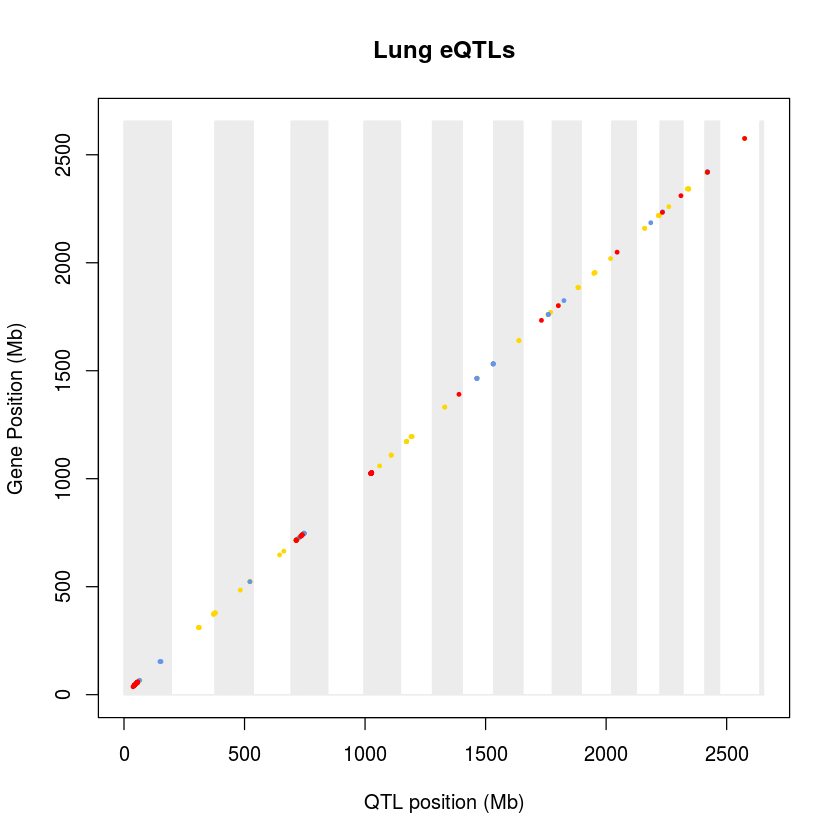

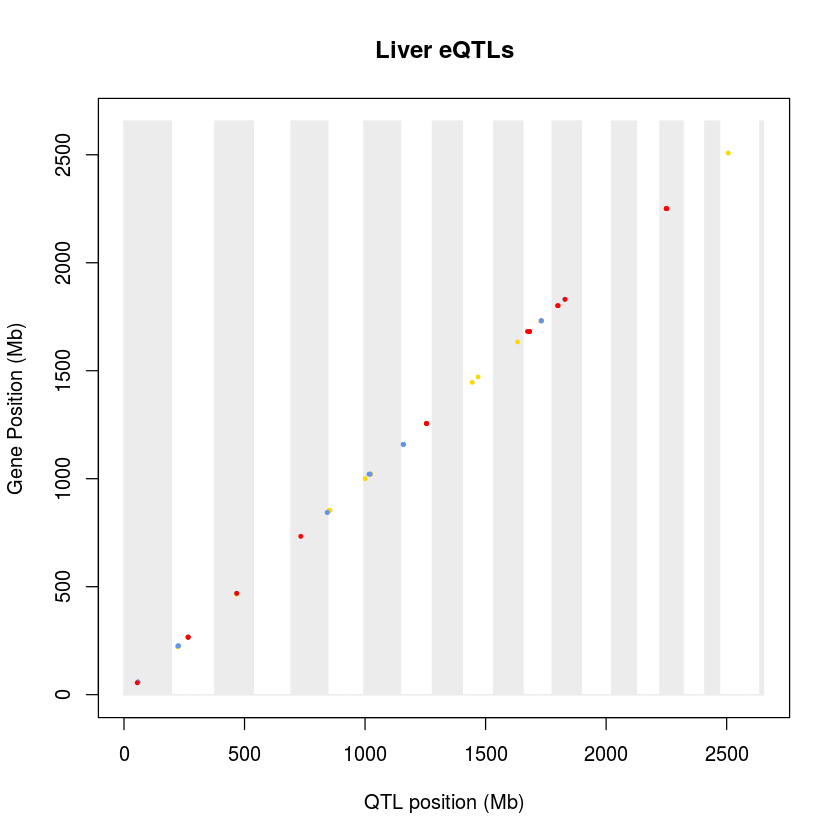

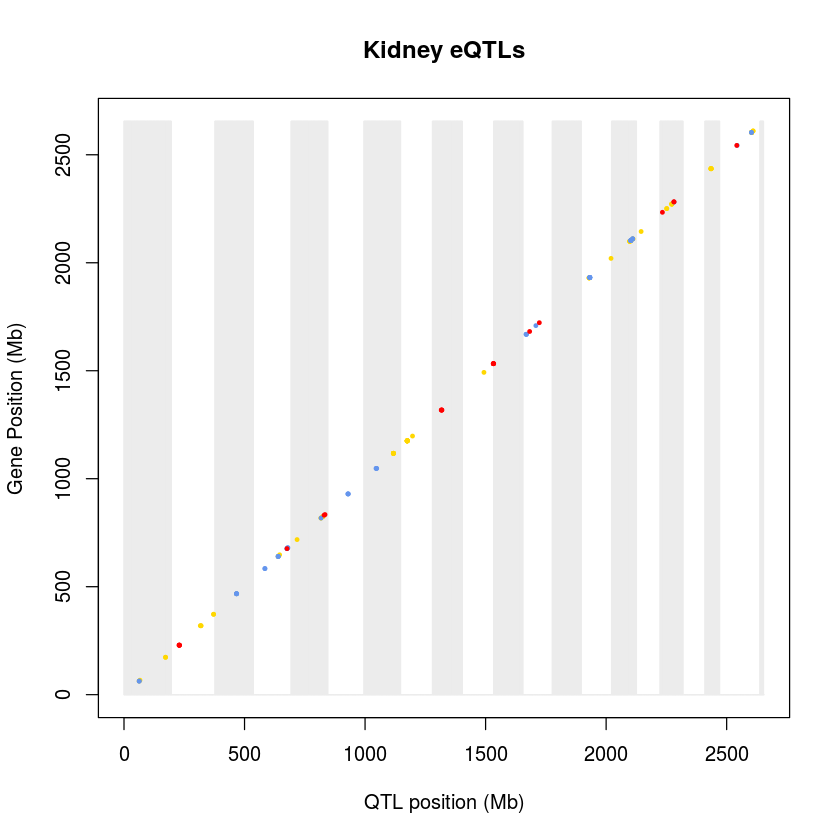

In [139]:
## Lung
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot eQTLs
plot(x=lung.x10, y=lung.y10, xlim=c(0,sum(chr.sizes$length)), ylim=c(0,sum(chr.sizes$length)), 
     pch=19, col="gold", xlab="QTL position (Mb)", ylab="Gene Position (Mb)", cex=0.4, main="Lung eQTLs")
points(x=lung.x5, y=lung.y5, pch=19, col="cornflowerblue", cex=0.4)
points(x=lung.x1, y=lung.y1, pch=19, col="red", cex=0.4)

## Liver
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot eQTLs
plot(x=liver.x10, y=liver.y10, xlim=c(0,sum(chr.sizes$length)), ylim=c(0,sum(chr.sizes$length)), 
     pch=19, col="gold", xlab="QTL position (Mb)", ylab="Gene Position (Mb)", cex=0.4, main="Liver eQTLs")
points(x=liver.x5, y=liver.y5, pch=19, col="cornflowerblue", cex=0.4)
points(x=liver.x1, y=liver.y1, pch=19, col="red", cex=0.4)


## Kidney
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot eQTLs
plot(x=kidney.x10, y=kidney.y10, xlim=c(0,sum(chr.sizes$length)), ylim=c(0,sum(chr.sizes$length)), 
     pch=19, col="gold", xlab="QTL position (Mb)", ylab="Gene Position (Mb)", cex=0.4, main="Kidney eQTLs")
points(x=kidney.x5, y=kidney.y5, pch=19, col="cornflowerblue", cex=0.4)
points(x=kidney.x1, y=kidney.y1, pch=19, col="red", cex=0.4)
